In [1]:
import json
import os
import pandas as pd
import py_stringmatching as sm
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from py_stringmatching.similarity_measure.token_sort import TokenSort

In [2]:
def save_listings(listings, filename):
    """
    Save DataFrame as JSON in nicer format than pandas.DataFrame.to_json
    
    Parameters:
        listings (pandas.DataFrame): DataFrame of listings
        filename (str): Name of file
    """
    
    if type(listings) is not list:
        listings_dict = listings.to_dict(orient='records')
    else:
        listings_dict = listings

    with open(filename, 'w') as f:
        print(json.dumps(listings_dict, indent=4), file=f)

In [3]:
def plot_listings(listings, maps=[], figsize=(12, 12), color=None, lat_range=None, lng_range=None, title=None, file=None):
    fig, ax = plt.subplots(figsize=figsize)
    
    # plot maps
    for m in maps:
        m.plot(ax=ax, alpha=0.4, edgecolor='grey', zorder=0)

    # plot listings
    sns.scatterplot(x='lng', y='lat', data=listings, hue=color)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # customize plot
    if lng_range is not None:
        plt.xlim(lng_range)
    
    if lat_range is not None:
        plt.ylim(lat_range)

    if title is not None:
        plt.title(title)
    
    # save figure
    if file is not None:
        plt.savefig(file)

In [4]:
data_path = '../../data'

# Listings

In [5]:
listings = pd.read_json(os.path.join(data_path, 'airbnb_listings_full.json'))
listings = listings.drop_duplicates(subset='id')
listings

,badges,bathroom_label,bathrooms,bed_label,bedroom_label,bedrooms,beds,city,guest_label,host_languages,...,price_string,rate,rate_type,rate_with_service_fee,weekly_price_factor,should_show_from_label,china_promotion_display_types,license,trust_signals,summary
0,[],1 shared bath,1.0,1 bed,1 bedroom,1.0,1.0,Chula Vista,5 guests,[],...,$35,"{'amount': 35.0, 'amount_formatted': '$35', 'c...",nightly,"{'amount': 35.0, 'amount_formatted': '$35', 'c...",0.93,False,[],None,None,None
1,[NEW],1 private bath,1.0,1 bed,1 bedroom,1.0,1.0,San Diego,2 guests,[],...,$30,"{'amount': 30.0, 'amount_formatted': '$30', 'c...",nightly,"{'amount': 30.0, 'amount_formatted': '$30', 'c...",0.95,False,[],None,None,None
2,[],1 bath,1.0,1 bed,Studio,0.0,1.0,San Diego,2 guests,[],...,$77,"{'amount': 77.0, 'amount_formatted': '$77', 'c...",nightly,"{'amount': 77.0, 'amount_formatted': '$77', 'c...",1.00,False,[],None,None,None
3,[],1 bath,1.0,1 bed,1 bedroom,1.0,1.0,San Diego,1 guest,"[en, es]",...,$25,"{'amount': 25.0, 'amount_formatted': '$25', 'c...",nightly,"{'amount': 25.0, 'amount_formatted': '$25', 'c...",1.00,False,[],None,None,None
4,[],1 bath,1.0,1 bed,Studio,0.0,1.0,San Diego,2 guests,"[en, es]",...,$67,"{'amount': 67.0, 'amount_formatted': '$67', 'c...",nightly,"{'amount': 67.0, 'amount_formatted': '$67', 'c...",0.95,False,[],None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,[],1 bath,1.0,1 bed,Studio,0.0,1.0,San Diego,2 guests,[],...,$75,"{'amount': 75.0, 'amount_formatted': '$75', 'c...",nightly,"{'amount': 75.0, 'amount_formatted': '$75', 'c...",1.00,False,[],None,None,None
7316,[],2 baths,2.0,6 beds,2 bedrooms,2.0,6.0,San Diego,10 guests,"[en, it, es]",...,$294,"{'amount': 294.0, 'amount_formatted': '$294', ...",nightly,"{'amount': 294.0, 'amount_formatted': '$294', ...",0.90,False,[],None,None,None
7317,[],4.5 baths,4.5,8 beds,5 bedrooms,5.0,8.0,San Diego,12 guests,"[en, es]",...,$728,"{'amount': 728.0, 'amount_formatted': '$728', ...",nightly,"{'amount': 728.0, 'amount_formatted': '$728', ...",0.90,False,[],None,None,None
7318,[],2 baths,2.0,4 beds,3 bedrooms,3.0,4.0,San Diego,8 guests,"[fr, es]",...,$193,"{'amount': 193.0, 'amount_formatted': '$193', ...",nightly,"{'amount': 193.0, 'amount_formatted': '$193', ...",0.90,False,[],None,None,None


## JSON

In [6]:
columns = [
    'id', 'property_type_id', 'tier_id', 'name',
    'bedrooms', 'beds', 'bathrooms', 'bedroom_label', 'bathroom_label',
    'person_capacity', 'city', 'neighborhood', 'coordinate', 'is_superhost', 'is_new_listing',
    'room_and_property_type', 'room_type_category', 'room_type', 'space_type', 'preview_amenity_names', 'amenity_ids',
]
listings_sub = listings[columns].copy()

listings_sub['content'] = listings.apply(lambda row: sorted(set(row.kicker_content['messages']) |
                                                            set(row.wide_kicker_content['messages'])), axis=1)
listings_sub['rate'] = listings.rate.apply(lambda x: x['amount'])
listings_sub = listings_sub.where(pd.notnull(listings_sub), None)
listings_sub

,id,property_type_id,tier_id,name,bedrooms,beds,bathrooms,bedroom_label,bathroom_label,person_capacity,...,is_superhost,is_new_listing,room_and_property_type,room_type_category,room_type,space_type,preview_amenity_names,amenity_ids,content,rate
0,13301630,2,0,2 Beds in my San Diego Master Bedroom Suite.,1,1,1,1 bedroom,1 shared bath,5,...,True,False,Private room in house,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 3, 4, 5, 69, 8, 9, 15, 25, 27, 30, 31, ...","[1 bed, Private room, Private room in house]",35.0
1,46026275,37,0,Simple Bedroom + Private bathroom + parking,1,1,1,1 bedroom,1 private bath,2,...,False,True,Private room in condominium,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 4, 36, 5, 37, 39, 8, 40, 41, 9...","[1 bed, Private room, Private room in condomin...",30.0
2,35774873,37,0,PERFECT STUDIO-DOWNTOWN LITTLE ITALY&PARKING SPOT,0,1,1,Studio,1 bath,2,...,True,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 129, 2, 4, 5, 8, 9, 77, 85, 21, 86, 89, 90...","[1 bed, Entire condominium]",77.0
3,8174032,1,0,Vacant bed for short stays,1,1,1,1 bedroom,1 bath,1,...,True,False,Private room in apartment,private_room,Private room,Private room,"[Wifi, Kitchen]","[2, 3, 35, 4, 36, 37, 38, 7, 39, 8, 41, 77, 21...","[1 bed, Private room, Private room in apartment]",25.0
4,20881330,53,0,Beautiful Studio in the Heart of San Diego!,0,1,1,Studio,1 bath,2,...,True,False,Entire guest suite,entire_home,Entire home/apt,Entire guest suite,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 4, 5, 8, 9, 73, 77, 85, 86, 87, 23, 89, 90...","[1 bed, Entire guest suite]",67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,42172804,37,0,Cozy Downtown Loft in a High-Rise!,0,1,1,Studio,1 bath,2,...,False,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 36, 4, 5, 40, 8, 9, 44, 45, 46...","[1 bed, Entire condominium]",75.0
7316,21040786,38,0,"VOTED ""BEST VIEW"" - entire home - central loca...",2,6,2,2 bedrooms,2 baths,10,...,False,False,Entire bungalow,entire_home,Entire home/apt,Entire bungalow,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 4, 5, 8, 9, 12, 23, 27, 30, 31, 33, 34,...","[6 beds, Entire bungalow]",294.0
7317,31581094,2,0,The Alfred Mansion,5,8,4.5,5 bedrooms,4.5 baths,12,...,True,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 65, 1, 2, 4, 7, 72, 8, 73, 9, 74, 77, 85,...","[8 beds, Entire house]",728.0
7318,18426407,2,0,Charming Hillcrest/Mission Hills 3 BR + House,3,4,2,3 bedrooms,2 baths,8,...,True,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 1, 4, 72, 8, 9, 77, 23, 89, 90, 91, 92, 9...","[4 beds, Entire house]",193.0


In [7]:
neighborhoods = pd.read_json(os.path.join(data_path, 'airbnb_neighborhoods.json'))
neighborhoods = neighborhoods.where(pd.notnull(neighborhoods), None)
neighborhoods = neighborhoods.explode('id')
neighborhoods

,coordinate,id,city,result,neighborhood
0,"{'latitude': 32.48697, 'longitude': -117.01481}",34225925,[Tijuana],"[{'address_components': [{'long_name': '20', '...",None
1,"{'latitude': 32.4877, 'longitude': -116.98716}",16556613,[Tijuana],"[{'address_components': [{'long_name': '6279',...",[Jardines de Agua Caliente]
2,"{'latitude': 32.48792, 'longitude': -117.01611}",45995600,[Tijuana],"[{'address_components': [{'long_name': '6424',...",None
3,"{'latitude': 32.49394, 'longitude': -116.97566}",43703586,[Tijuana],"[{'address_components': [{'long_name': '6001',...",None
4,"{'latitude': 32.49452, 'longitude': -116.97442}",31835433,[Tijuana],"[{'address_components': [{'long_name': '6018',...",None
...,...,...,...,...,...
7158,"{'latitude': 33.40656, 'longitude': -117.1948}",36101800,[Fallbrook],"[{'address_components': [{'long_name': '3026',...",None
7159,"{'latitude': 33.40951, 'longitude': -117.14296}",44449656,"[Rainbow, Fallbrook]","[{'address_components': [{'long_name': '5455',...",None
7160,"{'latitude': 33.41232, 'longitude': -117.20269}",3577387,"[Rainbow, Fallbrook]","[{'address_components': [{'long_name': '2063',...",None
7161,"{'latitude': 33.41698, 'longitude': -117.08728}",26958313,"[Pala, Rainbow]",[{'address_components': [{'long_name': '38750'...,None


In [8]:
print(f'Airbnb listings missing neighborhoods: {listings_sub.neighborhood.isna().sum()}')
print(f'Google listings missing neighborhoods: {neighborhoods.neighborhood.isna().sum()}')

Airbnb listings missing neighborhoods: 1865
Google listings missing neighborhoods: 1498


In [9]:
neighborhoods_airbnb_count = Counter()
listings_sub.neighborhood.dropna().apply(lambda x: neighborhoods_airbnb_count.update({x}))
neighborhoods_airbnb = set(neighborhoods_airbnb_count)
len(neighborhoods_airbnb)

113

In [10]:
neighborhoods_google_count = Counter()
neighborhoods.neighborhood.apply(neighborhoods_google_count.update)
neighborhoods_google = set(neighborhoods_google_count)
len(neighborhoods_google)

262

In [11]:
neighborhoods_airbnb - neighborhoods_google

{'Adams North',
 'Azalea/Hollywood Park',
 'Carmel Mountain',
 'Castle',
 'Cortez',
 'Fairmont Park',
 'Fairmont Village',
 'Gaslamp',
 'Horton Plaza',
 'Jamacha Lomita',
 'Midtown',
 'Mission Bay Park',
 'Mission Hill',
 'Park West',
 'Petco Park',
 'Rancho Penasquitos',
 'Redwood Village/Rolando Park',
 'Rolando',
 'Roseville/Fleet Ridge',
 'San Pasqual'}

Let's find potential matches between these Airbnb neighborhoods and the Google neighborhoods.

In [12]:
comparator = sm.GeneralizedJaccard(sim_func=TokenSort().get_sim_score, threshold=0.75)
tokenizer = sm.AlphabeticTokenizer()
threshold = 0.5
unmatched_neighborhoods = {}

for n in sorted(neighborhoods_airbnb-neighborhoods_google):
    sim_neighborhoods = {}
    
    for ng in neighborhoods_google-neighborhoods_airbnb:
        score = comparator.get_sim_score(tokenizer.tokenize(n), tokenizer.tokenize(ng))
        
        if score >= threshold:
            sim_neighborhoods[ng] = score
    
    print(f'{n}: {len(sim_neighborhoods)}')
    
    if len(sim_neighborhoods) > 0:
        for k, v in sorted(sim_neighborhoods.items(), key=lambda item: (-item[1], item[0])):
            print(f'\t{k}: {v}')
    else:
        count = Counter()
        ids = listings_sub[listings_sub.neighborhood==n].id.values
        neighborhoods[neighborhoods.id.isin(ids)].neighborhood.dropna().apply(count.update)
        unmatched_neighborhoods[n] = set(count)

Adams North: 0
Azalea/Hollywood Park: 1
	Azalea - Hollywood Park: 1.0
Carmel Mountain: 1
	Carmel Mountain Ranch: 0.6666666666666666
Castle: 0
Cortez: 1
	Cortez Hill: 0.5
Fairmont Park: 1
	Fairmount Park: 0.97
Fairmont Village: 1
	Fairmount Village: 0.97
Gaslamp: 1
	Gaslamp Quarter: 0.5
Horton Plaza: 0
Jamacha Lomita: 1
	Jamacha-Lomita: 1.0
Midtown: 1
	MIddletown: 0.82
Mission Bay Park: 1
	Mission Bay: 0.6666666666666666
Mission Hill: 1
	Mission Hills: 0.9450000000000001
Park West: 0
Petco Park: 0
Rancho Penasquitos: 1
	Rancho Peñasquitos: 0.6133333333333333
Redwood Village/Rolando Park: 3
	Redwood Village: 0.5
	Rolando Park: 0.5
	Rolando Village: 0.5
Rolando: 2
	Rolando Park: 0.5
	Rolando Village: 0.5
Roseville/Fleet Ridge: 1
	Roseville - Fleet Ridge: 1.0
San Pasqual: 1
	San Pasqual Valley: 0.6666666666666666


Now let's see how Google identified the unmatched Airbnb neighborhoods.

In [13]:
for k in unmatched_neighborhoods:
    print(k)
    
    for v in sorted(unmatched_neighborhoods[k]):
        print(f'\t{v}')

Adams North
	Mid-City
	Normal Heights
Castle
	City Heights
	Mid-City
Horton Plaza
	Gaslamp Quarter
Park West
	Bankers Hill
	Cortez Hill
	Hillcrest
	Little Italy
	MIddletown
Petco Park
	East Village


In [14]:
san_diego = gpd.read_file(os.path.join(data_path, 'tl_2018_06073_roads', 'tl_2018_06073_roads.shp'))
riverside = gpd.read_file(os.path.join(data_path, 'tl_2018_06065_roads', 'tl_2018_06065_roads.shp'))
mexico = gpd.read_file(os.path.join(data_path, 'nyu_2451_36766', 'bc_eje_vial.shp'))

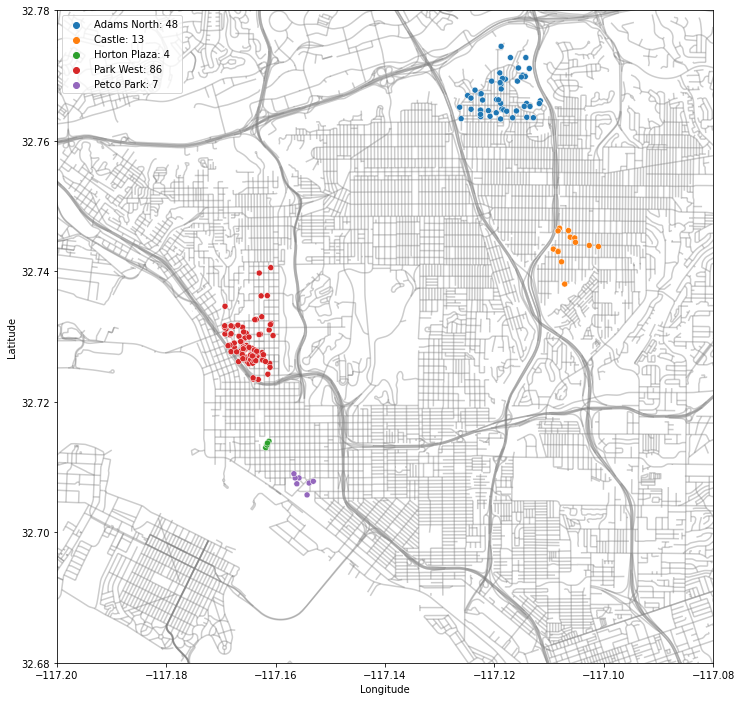

In [15]:
sub = listings[listings.neighborhood.isin(unmatched_neighborhoods)].sort_values(by='neighborhood').copy()

for n in unmatched_neighborhoods:
    i = sub.neighborhood==n
    sub.loc[i, 'neighborhood'] = sub.loc[i, 'neighborhood'].apply(lambda x: f'{x}: {sum(i)}')

plot_listings(sub, [san_diego], color='neighborhood', lat_range=[32.68, 32.78], lng_range=[-117.2, -117.08])
plt.legend(loc='upper left');

In [16]:
def process_neighborhood(neighborhood):
    set_dict = {
        'Adams North': {'Normal Heights', 'Mid-City'},
        'Castle': {'City Heights', 'Mid-City'},
        'Redwood Village/Rolando Park': {'Redwood Village', 'Rolando Park'}
    }
    
    if neighborhood in set_dict:
        return set_dict[neighborhood]
    
    rename_dict = {
        'Azalea/Hollywood Park': 'Azalea - Hollywood Park',
        'Carmel Mountain': 'Carmel Mountain Ranch',
        'Cortez': 'Cortez Hill',
        'Fairmont Park': 'Fairmount Park',
        'Fairmont Village': 'Fairmount Village',
        'Gaslamp': 'Gaslamp Quarter',
        'Horton Plaza': 'Gaslamp Quarter',
        'Jamacha Lomita': 'Jamacha-Lomita',
        'Midtown': 'MIddletown',
        'Mission Bay Park': 'Mission Bay',
        'Mission Hill': 'Mission Hills',
        'Petco Park': 'East Village',
        'Rancho Penasquitos': 'Rancho Peñasquitos',
        'Roseville/Fleet Ridge': 'Roseville - Fleet Ridge',
        'San Pasqual': 'San Pasqual Valley'
    }
    
    return {rename_dict[neighborhood]} if neighborhood in rename_dict else {neighborhood}

def combine_neighborhoods(x, y):
    # convert to sets if single string
    x = set(process_neighborhood(x) if type(x) is str else x or set())
    y = set(process_neighborhood(x) if type(y) is str else y or set())
    s = x.union(y)
    
    return sorted(s) if len(s) > 0 else None

def process_key(key, value):
    return int(value) if key in {'bedrooms', 'beds', 'property_type_id'} else value

In [17]:
listings_sub = listings_sub.set_index('id')
neighborhoods = neighborhoods.set_index('id')

neighborhoods_combined = listings_sub['neighborhood'].combine(neighborhoods['neighborhood'], combine_neighborhoods)
listings_sub['neighborhood'] = neighborhoods_combined

listings_sub = listings_sub.reset_index()
neighborhoods = neighborhoods.reset_index()

listings_sub

,id,property_type_id,tier_id,name,bedrooms,beds,bathrooms,bedroom_label,bathroom_label,person_capacity,...,is_superhost,is_new_listing,room_and_property_type,room_type_category,room_type,space_type,preview_amenity_names,amenity_ids,content,rate
0,13301630,2,0,2 Beds in my San Diego Master Bedroom Suite.,1,1,1,1 bedroom,1 shared bath,5,...,True,False,Private room in house,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 3, 4, 5, 69, 8, 9, 15, 25, 27, 30, 31, ...","[1 bed, Private room, Private room in house]",35.0
1,46026275,37,0,Simple Bedroom + Private bathroom + parking,1,1,1,1 bedroom,1 private bath,2,...,False,True,Private room in condominium,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 4, 36, 5, 37, 39, 8, 40, 41, 9...","[1 bed, Private room, Private room in condomin...",30.0
2,35774873,37,0,PERFECT STUDIO-DOWNTOWN LITTLE ITALY&PARKING SPOT,0,1,1,Studio,1 bath,2,...,True,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 129, 2, 4, 5, 8, 9, 77, 85, 21, 86, 89, 90...","[1 bed, Entire condominium]",77.0
3,8174032,1,0,Vacant bed for short stays,1,1,1,1 bedroom,1 bath,1,...,True,False,Private room in apartment,private_room,Private room,Private room,"[Wifi, Kitchen]","[2, 3, 35, 4, 36, 37, 38, 7, 39, 8, 41, 77, 21...","[1 bed, Private room, Private room in apartment]",25.0
4,20881330,53,0,Beautiful Studio in the Heart of San Diego!,0,1,1,Studio,1 bath,2,...,True,False,Entire guest suite,entire_home,Entire home/apt,Entire guest suite,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 4, 5, 8, 9, 73, 77, 85, 86, 87, 23, 89, 90...","[1 bed, Entire guest suite]",67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,42172804,37,0,Cozy Downtown Loft in a High-Rise!,0,1,1,Studio,1 bath,2,...,False,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 36, 4, 5, 40, 8, 9, 44, 45, 46...","[1 bed, Entire condominium]",75.0
7316,21040786,38,0,"VOTED ""BEST VIEW"" - entire home - central loca...",2,6,2,2 bedrooms,2 baths,10,...,False,False,Entire bungalow,entire_home,Entire home/apt,Entire bungalow,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 4, 5, 8, 9, 12, 23, 27, 30, 31, 33, 34,...","[6 beds, Entire bungalow]",294.0
7317,31581094,2,0,The Alfred Mansion,5,8,4.5,5 bedrooms,4.5 baths,12,...,True,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 65, 1, 2, 4, 7, 72, 8, 73, 9, 74, 77, 85,...","[8 beds, Entire house]",728.0
7318,18426407,2,0,Charming Hillcrest/Mission Hills 3 BR + House,3,4,2,3 bedrooms,2 baths,8,...,True,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 1, 4, 72, 8, 9, 77, 23, 89, 90, 91, 92, 9...","[4 beds, Entire house]",193.0


In [18]:
neighborhoods_combined = Counter()
listings_sub.neighborhood.apply(neighborhoods_combined.update)
len(neighborhoods_combined)

264

In [19]:
print(f'Airbnb listings missing neighborhoods: {listings_sub.neighborhood.isna().sum()}')

Airbnb listings missing neighborhoods: 1246


In [20]:
print(f"San Diego Airbnb listings missing neighborhoods: {listings_sub[listings_sub.city=='San Diego'].neighborhood.isna().sum()}")

San Diego Airbnb listings missing neighborhoods: 0


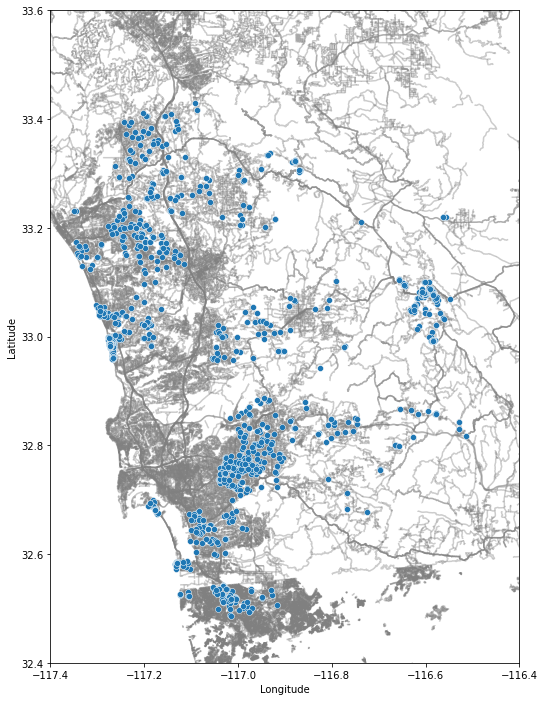

In [21]:
sub = listings_sub[listings_sub.neighborhood.isna()].copy()
sub['lat'] = sub.coordinate.apply(lambda x: x['latitude'])
sub['lng'] = sub.coordinate.apply(lambda x: x['longitude'])

plot_listings(sub, [san_diego, riverside, mexico], lat_range=[32.4, 33.6], lng_range=[-117.4, -116.4])

In [22]:
listings_dict = listings_sub.to_dict(orient='records')
listings_dict = [{k: process_key(k,v) for k, v in d.items() if v is not None and v != ""} for d in listings_dict]

save_listings(listings_dict, os.path.join(data_path, 'airbnb_listings.json'))

## CSV

In [23]:
columns = [
    'id', 'property_type_id', 'tier_id', 'name',
    'bedrooms', 'beds', 'bathrooms', 'bedroom_label', 'bathroom_label',
    'person_capacity', 'city', 'neighborhood', 'lat', 'lng', 'is_superhost', 'is_new_listing',
    'room_and_property_type', 'room_type_category', 'room_type', 'space_type', 'preview_amenity_names', 'amenity_ids'
]
listings_sub = listings[columns].copy()
listings_sub['kicker_content'] = listings.kicker_content.apply(lambda x: x['messages'])
listings_sub['wide_kicker_content'] = listings.wide_kicker_content.apply(lambda x: x['messages'])
listings_sub['rate'] = listings.rate.apply(lambda x: x['amount'])
listings_sub['name'] = listings_sub['name'].apply(lambda x: x.replace('\n', '\\n'))
listings_sub['name'] = listings_sub['name'].apply(lambda x: x.replace('\r', '\\r'))
listings_sub

,id,property_type_id,tier_id,name,bedrooms,beds,bathrooms,bedroom_label,bathroom_label,person_capacity,...,is_new_listing,room_and_property_type,room_type_category,room_type,space_type,preview_amenity_names,amenity_ids,kicker_content,wide_kicker_content,rate
0,13301630,2.0,0,2 Beds in my San Diego Master Bedroom Suite.,1.0,1.0,1.0,1 bedroom,1 shared bath,5,...,False,Private room in house,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 3, 4, 5, 69, 8, 9, 15, 25, 27, 30, 31, ...","[Private room, 1 bed]",[Private room in house],35.0
1,46026275,37.0,0,Simple Bedroom + Private bathroom + parking,1.0,1.0,1.0,1 bedroom,1 private bath,2,...,True,Private room in condominium,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 4, 36, 5, 37, 39, 8, 40, 41, 9...","[Private room, 1 bed]",[Private room in condominium],30.0
2,35774873,37.0,0,PERFECT STUDIO-DOWNTOWN LITTLE ITALY&PARKING SPOT,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 129, 2, 4, 5, 8, 9, 77, 85, 21, 86, 89, 90...","[Entire condominium, 1 bed]",[Entire condominium],77.0
3,8174032,1.0,0,Vacant bed for short stays,1.0,1.0,1.0,1 bedroom,1 bath,1,...,False,Private room in apartment,private_room,Private room,Private room,"[Wifi, Kitchen]","[2, 3, 35, 4, 36, 37, 38, 7, 39, 8, 41, 77, 21...","[Private room, 1 bed]",[Private room in apartment],25.0
4,20881330,53.0,0,Beautiful Studio in the Heart of San Diego!,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire guest suite,entire_home,Entire home/apt,Entire guest suite,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 4, 5, 8, 9, 73, 77, 85, 86, 87, 23, 89, 90...","[Entire guest suite, 1 bed]",[Entire guest suite],67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,42172804,37.0,0,Cozy Downtown Loft in a High-Rise!,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 36, 4, 5, 40, 8, 9, 44, 45, 46...","[Entire condominium, 1 bed]",[Entire condominium],75.0
7316,21040786,38.0,0,"VOTED ""BEST VIEW"" - entire home - central loca...",2.0,6.0,2.0,2 bedrooms,2 baths,10,...,False,Entire bungalow,entire_home,Entire home/apt,Entire bungalow,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 4, 5, 8, 9, 12, 23, 27, 30, 31, 33, 34,...","[Entire bungalow, 6 beds]",[Entire bungalow],294.0
7317,31581094,2.0,0,The Alfred Mansion,5.0,8.0,4.5,5 bedrooms,4.5 baths,12,...,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 65, 1, 2, 4, 7, 72, 8, 73, 9, 74, 77, 85,...","[Entire house, 8 beds]",[Entire house],728.0
7318,18426407,2.0,0,Charming Hillcrest/Mission Hills 3 BR + House,3.0,4.0,2.0,3 bedrooms,2 baths,8,...,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 1, 4, 72, 8, 9, 77, 23, 89, 90, 91, 92, 9...","[Entire house, 4 beds]",[Entire house],193.0


In [24]:
listings_sub.to_csv(os.path.join(data_path, 'airbnb_listings.csv'), index=False)

# Reviews

In [25]:
reviews = pd.read_json(os.path.join(data_path, 'airbnb_reviews_full.json'))
reviews = reviews.drop_duplicates(subset='id')
reviews

,author,author_id,can_be_edited,comments,created_at,id,id_str,listing_id,recipient_id,collection_tag,listing,rating,recipient,response,role,language,user_flag
0,"{'first_name': 'Reginald', 'has_profile_pic': ...",328321073,False,magnificent,2020-08-20 22:48:25+00:00,653954608,653954608,13301630,40442827,NaN,"{'id': 13301630, 'listing_id_str': '13301630',...",5,"{'first_name': 'Gary', 'has_profile_pic': True...",,guest,en,NaN
1,"{'first_name': 'Reginald', 'has_profile_pic': ...",328321073,False,I have been Garry's guest for the last 6 month...,2020-06-15 23:46:10+00:00,629997649,629997649,13301630,40442827,NaN,"{'id': 13301630, 'listing_id_str': '13301630',...",5,"{'first_name': 'Gary', 'has_profile_pic': True...",,guest,en,NaN
2,"{'first_name': 'John', 'has_profile_pic': True...",31735215,False,Gary is a wonderful host.\nHe is very nice and...,2019-12-29 00:59:02+00:00,583538843,583538843,13301630,40442827,NaN,"{'id': 13301630, 'listing_id_str': '13301630',...",5,"{'first_name': 'Gary', 'has_profile_pic': True...",,guest,en,NaN
3,"{'first_name': 'Lawang', 'has_profile_pic': Tr...",212339508,False,Recommended to all for a cozy place with great...,2018-09-03 22:56:57+00:00,318521505,318521505,13301630,40442827,NaN,"{'id': 13301630, 'listing_id_str': '13301630',...",5,"{'first_name': 'Gary', 'has_profile_pic': True...",,guest,en,NaN
4,"{'first_name': 'Brittany', 'has_profile_pic': ...",124868001,False,Gary was very friendly and welcoming! And the ...,2018-07-22 23:49:03+00:00,295091676,295091676,13301630,40442827,NaN,"{'id': 13301630, 'listing_id_str': '13301630',...",5,"{'first_name': 'Gary', 'has_profile_pic': True...",,guest,en,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426202,"{'first_name': 'Celia', 'has_profile_pic': Tru...",18324884,False,"I had a great stay, the house was super clean,...",2019-03-20 22:27:36+00:00,426354473,426354473,28319097,3808442,NaN,"{'id': 28319097, 'listing_id_str': '28319097',...",5,"{'first_name': 'Saman', 'has_profile_pic': Tru...",,guest,en,NaN
426203,"{'first_name': 'Stephanie', 'has_profile_pic':...",46016736,False,Location is great and host is wonderful.\nRoom...,2019-01-17 23:23:48+00:00,402227519,402227519,28319097,3808442,NaN,"{'id': 28319097, 'listing_id_str': '28319097',...",3,"{'first_name': 'Saman', 'has_profile_pic': Tru...",,guest,en,NaN
426204,"{'first_name': 'Shimpei', 'has_profile_pic': T...",74203189,False,Very calm and relaxing room and located at a c...,2019-01-02 23:41:15+00:00,366547778,366547778,28319097,3808442,NaN,"{'id': 28319097, 'listing_id_str': '28319097',...",5,"{'first_name': 'Saman', 'has_profile_pic': Tru...",,guest,en,NaN
426205,"{'first_name': 'April', 'has_profile_pic': Tru...",120325436,False,As beautiful as shown in the photos! Cute yard...,2019-01-01 21:10:33+00:00,365733179,365733179,28319097,3808442,NaN,"{'id': 28319097, 'listing_id_str': '28319097',...",5,"{'first_name': 'Saman', 'has_profile_pic': Tru...",,guest,en,NaN


## JSON

In [26]:
columns = [
    'id', 'listing_id', 'author_id', 'recipient_id', 'rating', 'comments', 'response', 'created_at'
]
reviews_sub = reviews[columns].copy()
reviews_sub['created_at'] = reviews_sub.created_at.apply(lambda x: str(x).replace('+00:00','Z'))
reviews_sub

,id,listing_id,author_id,recipient_id,rating,comments,response,created_at
0,653954608,13301630,328321073,40442827,5,magnificent,,2020-08-20 22:48:25Z
1,629997649,13301630,328321073,40442827,5,I have been Garry's guest for the last 6 month...,,2020-06-15 23:46:10Z
2,583538843,13301630,31735215,40442827,5,Gary is a wonderful host.\nHe is very nice and...,,2019-12-29 00:59:02Z
3,318521505,13301630,212339508,40442827,5,Recommended to all for a cozy place with great...,,2018-09-03 22:56:57Z
4,295091676,13301630,124868001,40442827,5,Gary was very friendly and welcoming! And the ...,,2018-07-22 23:49:03Z
...,...,...,...,...,...,...,...,...
426202,426354473,28319097,18324884,3808442,5,"I had a great stay, the house was super clean,...",,2019-03-20 22:27:36Z
426203,402227519,28319097,46016736,3808442,3,Location is great and host is wonderful.\nRoom...,,2019-01-17 23:23:48Z
426204,366547778,28319097,74203189,3808442,5,Very calm and relaxing room and located at a c...,,2019-01-02 23:41:15Z
426205,365733179,28319097,120325436,3808442,5,As beautiful as shown in the photos! Cute yard...,,2019-01-01 21:10:33Z


In [27]:
reviews_dict = reviews_sub.to_dict(orient='records')
reviews_dict = [{k: v for k, v in d.items() if v != ""} for d in reviews_dict]

save_listings(reviews_dict, os.path.join(data_path, 'airbnb_reviews.json'))

## CSV

In [28]:
columns = [
    'id', 'listing_id', 'author_id', 'recipient_id', 'rating', 'comments', 'response', 'created_at'
]
reviews_sub = reviews[columns].copy()
reviews_sub['created_at'] = reviews_sub.created_at.apply(lambda x: str(x).replace('+00:00','Z'))
reviews_sub['comments'] = reviews_sub['comments'].apply(lambda x: x.replace('\n', '\\n'))
reviews_sub['comments'] = reviews_sub['comments'].apply(lambda x: x.replace('\r', '\\r'))
reviews_sub['response'] = reviews_sub['response'].apply(lambda x: x.replace('\n', '\\n'))
reviews_sub['response'] = reviews_sub['response'].apply(lambda x: x.replace('\r', '\\r'))
reviews_sub

,id,listing_id,author_id,recipient_id,rating,comments,response,created_at
0,653954608,13301630,328321073,40442827,5,magnificent,,2020-08-20 22:48:25Z
1,629997649,13301630,328321073,40442827,5,I have been Garry's guest for the last 6 month...,,2020-06-15 23:46:10Z
2,583538843,13301630,31735215,40442827,5,Gary is a wonderful host.\nHe is very nice and...,,2019-12-29 00:59:02Z
3,318521505,13301630,212339508,40442827,5,Recommended to all for a cozy place with great...,,2018-09-03 22:56:57Z
4,295091676,13301630,124868001,40442827,5,Gary was very friendly and welcoming! And the ...,,2018-07-22 23:49:03Z
...,...,...,...,...,...,...,...,...
426202,426354473,28319097,18324884,3808442,5,"I had a great stay, the house was super clean,...",,2019-03-20 22:27:36Z
426203,402227519,28319097,46016736,3808442,3,Location is great and host is wonderful.\nRoom...,,2019-01-17 23:23:48Z
426204,366547778,28319097,74203189,3808442,5,Very calm and relaxing room and located at a c...,,2019-01-02 23:41:15Z
426205,365733179,28319097,120325436,3808442,5,As beautiful as shown in the photos! Cute yard...,,2019-01-01 21:10:33Z


In [29]:
reviews_sub.to_csv(os.path.join(data_path, 'airbnb_reviews.csv'), index=False, na_rep=None)